# Bagging

### 1. Import necessary libraries:

In [1]:
import pandas as pd
import math
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.tree import DecisionTreeRegressor, plot_tree, export_text
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn import metrics
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.inspection import permutation_importance
from sklearn.ensemble import BaggingRegressor
from sklearn.preprocessing import StandardScaler, OneHotEncoder, PolynomialFeatures
from sklearn.compose import ColumnTransformer

# others
# from mltools import classification_tools as CT
from mltools import model_tools as MT
from mltools import regression_tools as RT

### 2. Load data as a Pandas DataFrame:

In [2]:
path_irrad = "../data/G07A_DATOS_IRRAD.csv"
df_orig_irrad = pd.read_csv(path_irrad)

# Parse the date (string) for it to be a datetime with format yyyy/mm/dd
df_orig_irrad['FECHA'] = pd.to_datetime(df_orig_irrad['FECHA'], format='%Y-%m-%d')

s = df_orig_irrad.loc[:,'FECHA']
df_orig_irrad['FECHA'] =  s.dt.date

In [3]:
path_util = "../data/G07A_DATOS_UTIL.csv"
df_orig_util = pd.read_csv(path_util)

# Parse the date (string) for it to be a datetime with format yyyy/mm/dd
df_orig_util['FECHA'] = pd.to_datetime(df_orig_util['FECHA'], format='%Y-%m-%d')

s = df_orig_util.loc[:,'FECHA']
df_orig_util['FECHA'] =  s.dt.date

In [4]:
# Unimos ambos dataframes
df = pd.merge(df_orig_irrad, df_orig_util, on=['FECHA', 'ANNO', 'MES', 'DIA', 'DIASEM'] , how='inner')

# Separamos el DataFrame en partes según la descripción
fecha_df = df[['ANNO', 'MES', 'DIA', 'DIASEM']]
irrad_df = df.filter(regex='^IRRAD')
util_df = df.filter(regex='^UTIL')

# Transformamos los DataFrames de irradiación y utilización
irrad_melted = irrad_df.melt(var_name='FranjaHoraria', value_name='Irradiacion')
util_melted = util_df.melt(var_name='FranjaHoraria', value_name='Utilizacion')

# Ajustamos la franja horaria para extracción
irrad_melted['FranjaHoraria'] = irrad_melted['FranjaHoraria'].str.extract('(\d+)')
util_melted['FranjaHoraria'] = util_melted['FranjaHoraria'].str.extract('(\d+)')

# Repetimos fecha_df para cada franja horaria (8 veces)
fecha_expanded = pd.concat([fecha_df]*irrad_df.shape[1], ignore_index=True)
df_repetido = fecha_expanded.reset_index(drop=True)
irrad_melted = irrad_melted.reset_index(drop=True)
util_melted = util_melted.reset_index(drop=True)

# Extraemos las columnas específicas y resetear sus índices
irrad_serie = irrad_melted['Irradiacion'].reset_index(drop=True)
franja_serie = irrad_melted['FranjaHoraria'].reset_index(drop=True)  # Incluir la columna 'franja horaria'
util_serie = util_melted['Utilizacion'].reset_index(drop=True)

# Unimos los DataFrames/series
df_final = pd.concat([df_repetido, franja_serie, irrad_serie, util_serie], axis=1)

<>:14: SyntaxWarning: invalid escape sequence '\d'
<>:15: SyntaxWarning: invalid escape sequence '\d'
<>:14: SyntaxWarning: invalid escape sequence '\d'
<>:15: SyntaxWarning: invalid escape sequence '\d'
C:\Users\belus\AppData\Local\Temp\ipykernel_14164\2982798963.py:14: SyntaxWarning: invalid escape sequence '\d'
  irrad_melted['FranjaHoraria'] = irrad_melted['FranjaHoraria'].str.extract('(\d+)')
C:\Users\belus\AppData\Local\Temp\ipykernel_14164\2982798963.py:15: SyntaxWarning: invalid escape sequence '\d'
  util_melted['FranjaHoraria'] = util_melted['FranjaHoraria'].str.extract('(\d+)')


In [5]:
# Convertimos 'FranjaHoraria' a integer y ordenamos el df
df_final['FranjaHoraria'] = df_final['FranjaHoraria'].astype(int)
df_final = df_final.sort_values(by=['ANNO', 'MES', 'DIA', 'FranjaHoraria'])

# Calculamos los lags de irradiación
df_final['Irradiacion_lag1'] = df_final['Irradiacion'].shift(1)
df_final['Irradiacion_lag2'] = df_final['Irradiacion'].shift(2)
df_final['Irradiacion_lag8'] = df_final['Irradiacion'].shift(8) # un día antes
df_final['Irradiacion_lag365'] = df_final['Irradiacion'].shift(365*8) # un año antes

# Calculamos los lags de utilización
df_final['Utilizacion_lag1'] = df_final['Utilizacion'].shift(1)
df_final['Utilizacion_lag2'] = df_final['Utilizacion'].shift(2)
df_final['Utilizacion_lag8'] = df_final['Utilizacion'].shift(8) # un día antes
df_final['Utilizacion_lag365'] = df_final['Utilizacion'].shift(365*8) # un año antes

# Eliminamos los valores nulos
df_final = df_final.dropna()

# Cambiamos ANNO, MES, DIA, DIASEM y FranjaHoraria a categóricos
df_final['ANNO'] = df_final['ANNO'].astype('category')
df_final['MES'] = df_final['MES'].astype('category')
df_final['DIA'] = df_final['DIA'].astype('category')
df_final['DIASEM'] = df_final['DIASEM'].astype('category')
df_final['FranjaHoraria'] = df_final['FranjaHoraria'].astype('category')

### 3. Split the data into training and test sets:

In [6]:
# Inputs of the model
INPUTS_NUM = ['Irradiacion', 'Irradiacion_lag1', 'Irradiacion_lag2', 'Irradiacion_lag8', 'Irradiacion_lag365', 'Utilizacion_lag1', 'Utilizacion_lag2', 'Utilizacion_lag8', 'Utilizacion_lag365']
INPUTS_CAT = ['ANNO', 'MES', 'DIA', 'DIASEM', 'FranjaHoraria'] # Weekday is numerical in this case - Intervention variables
INPUTS = INPUTS_NUM + INPUTS_CAT
OUTPUT = 'Utilizacion'

#numeric_transformer = Pipeline(steps=[('scaler', StandardScaler())])
#categorical_transformer = Pipeline(steps=[('onehot', OneHotEncoder(handle_unknown='ignore'))])

# We have categorical inputs with many classes. We will create dummy variables automatically after
X = df_final[INPUTS]
y = df_final[OUTPUT]

# Divide the data into training and test sets 
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                   test_size=0.2,  #percentage of test data
                                                   random_state=999) #seed for replication

# Create dataset to store model predictions
dfTR_eval = X_train.copy()
dfTR_eval['Utilizacion'] = y_train
dfTS_eval = X_test.copy()
dfTS_eval['Utilizacion'] = y_test

# Print the sizes of the training and test datasets
print("Size of the training set:", dfTR_eval.shape)
print("Size of the test set:", dfTS_eval.shape)

Size of the training set: (11692, 15)
Size of the test set: (2924, 15)


### 4. Training of Bagging Regressor:

#### 4.1 Bagging base estimator
 - criterion='squared_error',
 - min_impurity_decrease= 0.001,
 - min_samples_leaf= 10,
 - min_samples_split= 1,
 - random_state = 999


In [7]:
numeric_transformer = Pipeline(steps=[('scaler', StandardScaler())])

# Prepare the categorical variables by encoding the categories
categorical_transformer = Pipeline(steps=[('onehot', OneHotEncoder(handle_unknown='ignore'))])

# Create a preprocessor to perform the steps defined above
preprocessor = ColumnTransformer(transformers=[
        ('num', numeric_transformer, INPUTS_NUM),
        ('cat', categorical_transformer, INPUTS_CAT)
        ])

In [8]:
# grid in min_impurity x min_samples_leaf x min_samples_split
param = {'DT__min_impurity_decrease': np.arange(0, 0.001 * np.var(y_train),0.001), # Minimum impurity to decrease in each split
         'DT__min_samples_leaf': np.arange(1,10,1), # Minimum number of obs in a terminal node
         'DT__min_samples_split':  np.arange(1,10,1)} # Minimum number of obs in node to keep cutting

base_estimator =  Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('DT',DecisionTreeRegressor(criterion='squared_error',  # impurity measure
                                #min_impurity_decrease=0.001,
                                #min_samples_split=2, # Minimum number of obs in node to keep cutting
                                #min_samples_leaf=10, # Minimum number of obs in a terminal node
                                random_state=999))]) # For replication

# We use Grid Search Cross Validation to find the best parameter for the model in the grid defined 
nFolds = 10
base_estimator_fit = GridSearchCV(estimator=base_estimator, # Structure of the model to use
                       param_grid=param, # Defined grid to search in
                       n_jobs=-1, # Number of cores to use (parallelize)
                       cv=nFolds) # Number of Folds 

In [9]:
base_estimator_fit.fit(X_train, y_train)

c:\Users\belus\anaconda3\envs\Assessment1\Lib\site-packages\sklearn\model_selection\_validation.py:547: FitFailedWarning: 
90 fits failed out of a total of 810.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
90 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\belus\anaconda3\envs\Assessment1\Lib\site-packages\sklearn\model_selection\_validation.py", line 895, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\belus\anaconda3\envs\Assessment1\Lib\site-packages\sklearn\base.py", line 1474, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\belus\anaconda3\envs\Assessment1\Lib\site-packages

GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('scaler',
                                                                                          StandardScaler())]),
                                                                         ['Irradiacion',
                                                                          'Irradiacion_lag1',
                                                                          'Irradiacion_lag2',
                                                                          'Irradiacion_lag8',
                                                                          'Irradiacion_lag365',
                                                                          'Utilizacion_lag1',
                                                                          'Utilizacion_lag2',
                                                                          'Utilizacion_lag8',
                                                                          'Utilizacion_lag365']),
                                                                        ('cat',
                                                                         Pipeline(steps=[('onehot',
                                                                                          OneHotEncoder(handle_unknown='ignore'))]),
                                                                         ['ANNO',
                                                                          'MES',
                                                                          'DIA',
                                                                          'DIASEM',
                                                                          'FranjaHoraria'])])),
                                       ('DT',
                                        DecisionTreeRegressor(random_state=999))]),
             n_jobs=-1,
             param_grid={'DT__min_impurity_decrease': array([0.]),
                         'DT__min_samples_leaf': array([1, 2, 3, 4, 5, 6, 7, 8, 9]),
                         'DT__min_samples_split': array([1, 2, 3, 4, 5, 6, 7, 8, 9])})

In [10]:
base_estimator_fit.best_estimator_['DT'].get_params()

{'ccp_alpha': 0.0,
 'criterion': 'squared_error',
 'max_depth': None,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 9,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'monotonic_cst': None,
 'random_state': 999,
 'splitter': 'best'}

In [11]:
# Predict
y_train_est = base_estimator_fit.predict(X_train)
y_test_est = base_estimator_fit.predict(X_test)

# Obtain a report of the model based on predictions
dfTR_eval['DT_pred'] = y_train_est
dfTS_eval['DT_pred'] = y_test_est

# Training and test MAE - Mean Absolute error
print('Training MAE:', mean_absolute_error(dfTR_eval['Utilizacion'], dfTR_eval['DT_pred']))
print('Test MAE:', mean_absolute_error(dfTS_eval['Utilizacion'], dfTS_eval['DT_pred']))
# Training and test RMSE - Root Mean Square Error
print('Training RMSE:', math.sqrt(mean_squared_error(dfTR_eval['Utilizacion'], dfTR_eval['DT_pred'])))
print('Test RMSE:', math.sqrt(mean_squared_error(dfTS_eval['Utilizacion'], dfTS_eval['DT_pred'])))
# Training and test r^2 
print('Training R2:', r2_score(dfTR_eval['Utilizacion'], dfTR_eval['DT_pred']))
print('Test R2:', r2_score(dfTS_eval['Utilizacion'], dfTS_eval['DT_pred']))

Training MAE: 0.010760116859595546
Test MAE: 0.016416007363727392
Training RMSE: 0.0207533767782884
Test RMSE: 0.03137852012215508
Training R2: 0.9678731786899102
Test R2: 0.9242953107770355


In [12]:
base_estimator =  Pipeline(steps=[
    # ('preprocessor', preprocessor),
    ('DT',DecisionTreeRegressor(criterion='squared_error',  # impurity measure
                                min_impurity_decrease=0.001,
                                min_samples_split=2, # Minimum number of obs in node to keep cutting
                                min_samples_leaf=9, # Minimum number of obs in a terminal node
                                random_state=999))])

#### 4.2 Ensemble Creation and Optimal Number Selection
- Range Selection: Search between 20 and 150, incrementing by 5 at each step.
- Scoring method in GridSearchCV: 'neg_mean_absolute_error'

In [13]:
# Find optim nº of trees in the ensemble
param = {'BT__n_estimators': range(20, 150, 5)} # Number of trees to aggregate

pipe =  Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('BT', BaggingRegressor(estimator=base_estimator,
                            random_state=150))])

# We use Grid Search Cross Validation to find the best parameter for the model in the grid defined 
nFolds = 10
bt_fit = GridSearchCV(estimator=pipe, # Structure of the model to use
                       param_grid=param, # Defined grid to search in
                       n_jobs=-1, # Number of cores to use (parallelize)
                       scoring='neg_mean_absolute_error', 
                       cv=nFolds) # Number of Folds 

In [14]:
# Fit the bagged trees
bt_fit.fit(X_train, y_train) # Search in grid

GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('scaler',
                                                                                          StandardScaler())]),
                                                                         ['Irradiacion',
                                                                          'Irradiacion_lag1',
                                                                          'Irradiacion_lag2',
                                                                          'Irradiacion_lag8',
                                                                          'Irradiacion_lag365',
                                                                          'Utilizacion_lag1',
                                                                          'Utilizacion_lag2',
                                                                          'Utilizacion_lag8',
                                                                          'Utilizacion_lag365']),
                                                                        ('cat',
                                                                         Pipeline(steps=[('onehot',
                                                                                          OneHotEncoder(handle_unknown='ignore'))]),
                                                                         ['ANNO',
                                                                          'MES',
                                                                          'DIA',
                                                                          'DIASEM',
                                                                          'FranjaHoraria'])])),
                                       ('BT',
                                        BaggingRegressor(estimator=Pipeline(steps=[('DT',
                                                                                    DecisionTreeRegressor(min_impurity_decrease=0.001,
                                                                                                          min_samples_leaf=9,
                                                                                                          random_state=999))]),
                                                         random_state=150))]),
             n_jobs=-1, param_grid={'BT__n_estimators': range(20, 150, 5)},
             scoring='neg_mean_absolute_error')

In [15]:
# Show the best grid parameter combination found by CV
# bt_fit.best_estimator_['BT'].get_params()
num_trees = bt_fit.best_estimator_['BT'].n_estimators
print(num_trees)

55


#### 4.3. Bagging Output

In [16]:
# Predict
y_train_est = bt_fit.predict(X_train)
y_test_est = bt_fit.predict(X_test)
# Obtain a report of the model based on predictions
dfTR_eval['BT_pred'] = y_train_est
dfTS_eval['BT_pred'] = y_test_est

# Training and test MAE - Mean Absolute error
print('Training MAE:', mean_absolute_error(dfTR_eval['Utilizacion'], dfTR_eval['BT_pred']))
print('Test MAE:', mean_absolute_error(dfTS_eval['Utilizacion'], dfTS_eval['BT_pred']))
# Training and test RMSE - Root Mean Square Error
print('Training RMSE:', math.sqrt(mean_squared_error(dfTR_eval['Utilizacion'], dfTR_eval['BT_pred'])))
print('Test RMSE:', math.sqrt(mean_squared_error(dfTS_eval['Utilizacion'], dfTS_eval['BT_pred'])))
# Training and test r^2 
print('Training R2:', r2_score(dfTR_eval['Utilizacion'], dfTR_eval['BT_pred']))
print('Test R2:', r2_score(dfTS_eval['Utilizacion'], dfTS_eval['BT_pred']))


Training MAE: 0.034799947099700114
Test MAE: 0.035642310646443985
Training RMSE: 0.059111065370373486
Test RMSE: 0.059439066305100735
Training R2: 0.7393679681267216
Test R2: 0.728354932585709


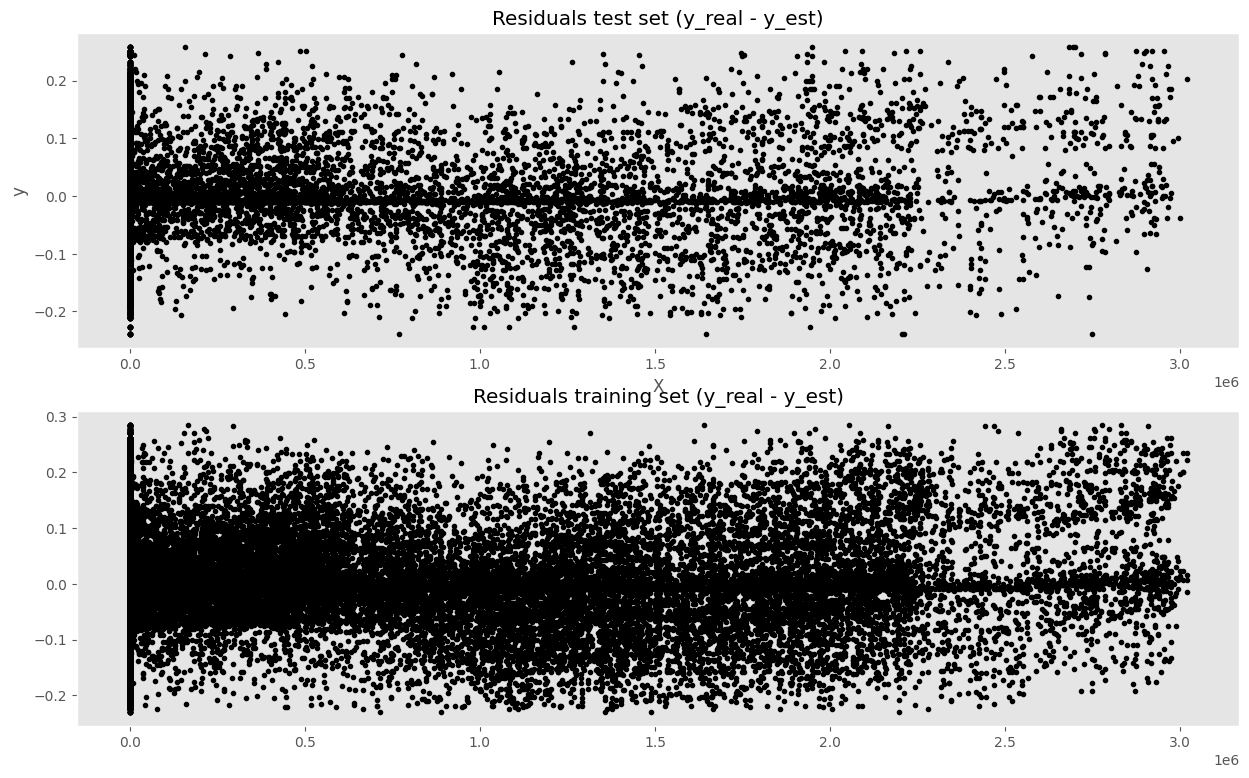

In [17]:
# Plot residuals

plt.figure(figsize=(15, 9))

plt.subplot(2,1,2)
plt.plot(X_train, y_train - y_train_est, '.', color = 'black')
plt.grid()
plt.title(f'Residuals training set (y_real - y_est)')

plt.subplot(2,1,1)
plt.plot(X_test, y_test - y_test_est, '.', color = 'black')
plt.title(f'Residuals test set (y_real - y_est)')
plt.grid()
plt.xlabel('X')
plt.ylabel('y')
plt.show()

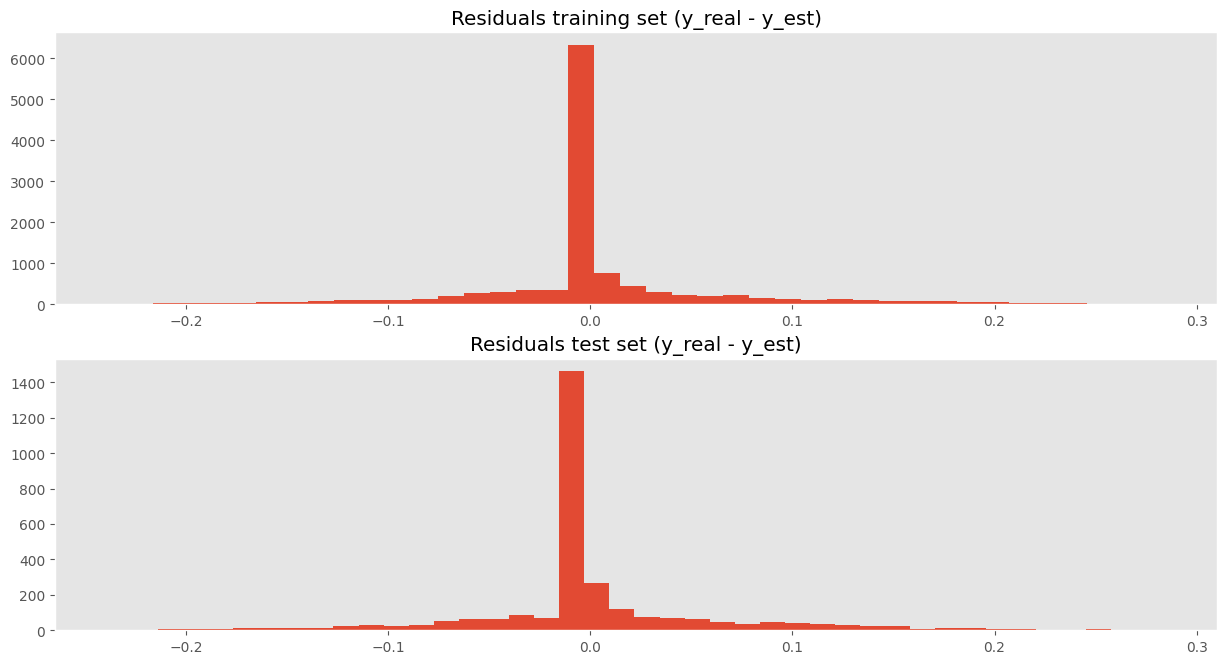

In [18]:
# Histogram of residuals

plt.figure(figsize=(15, 12))

ax=plt.subplot(3,1,2)
plt.hist(y_train - y_train_est, bins = 40, label='Residuals training set')
plt.grid()
plt.title(f'Residuals training set (y_real - y_est)')

plt.subplot(3,1,3, sharex = ax)
plt.hist(y_test - y_test_est, bins = 40, label='Residuals training set')
plt.grid()
plt.title(f'Residuals test set (y_real - y_est)')
plt.show()

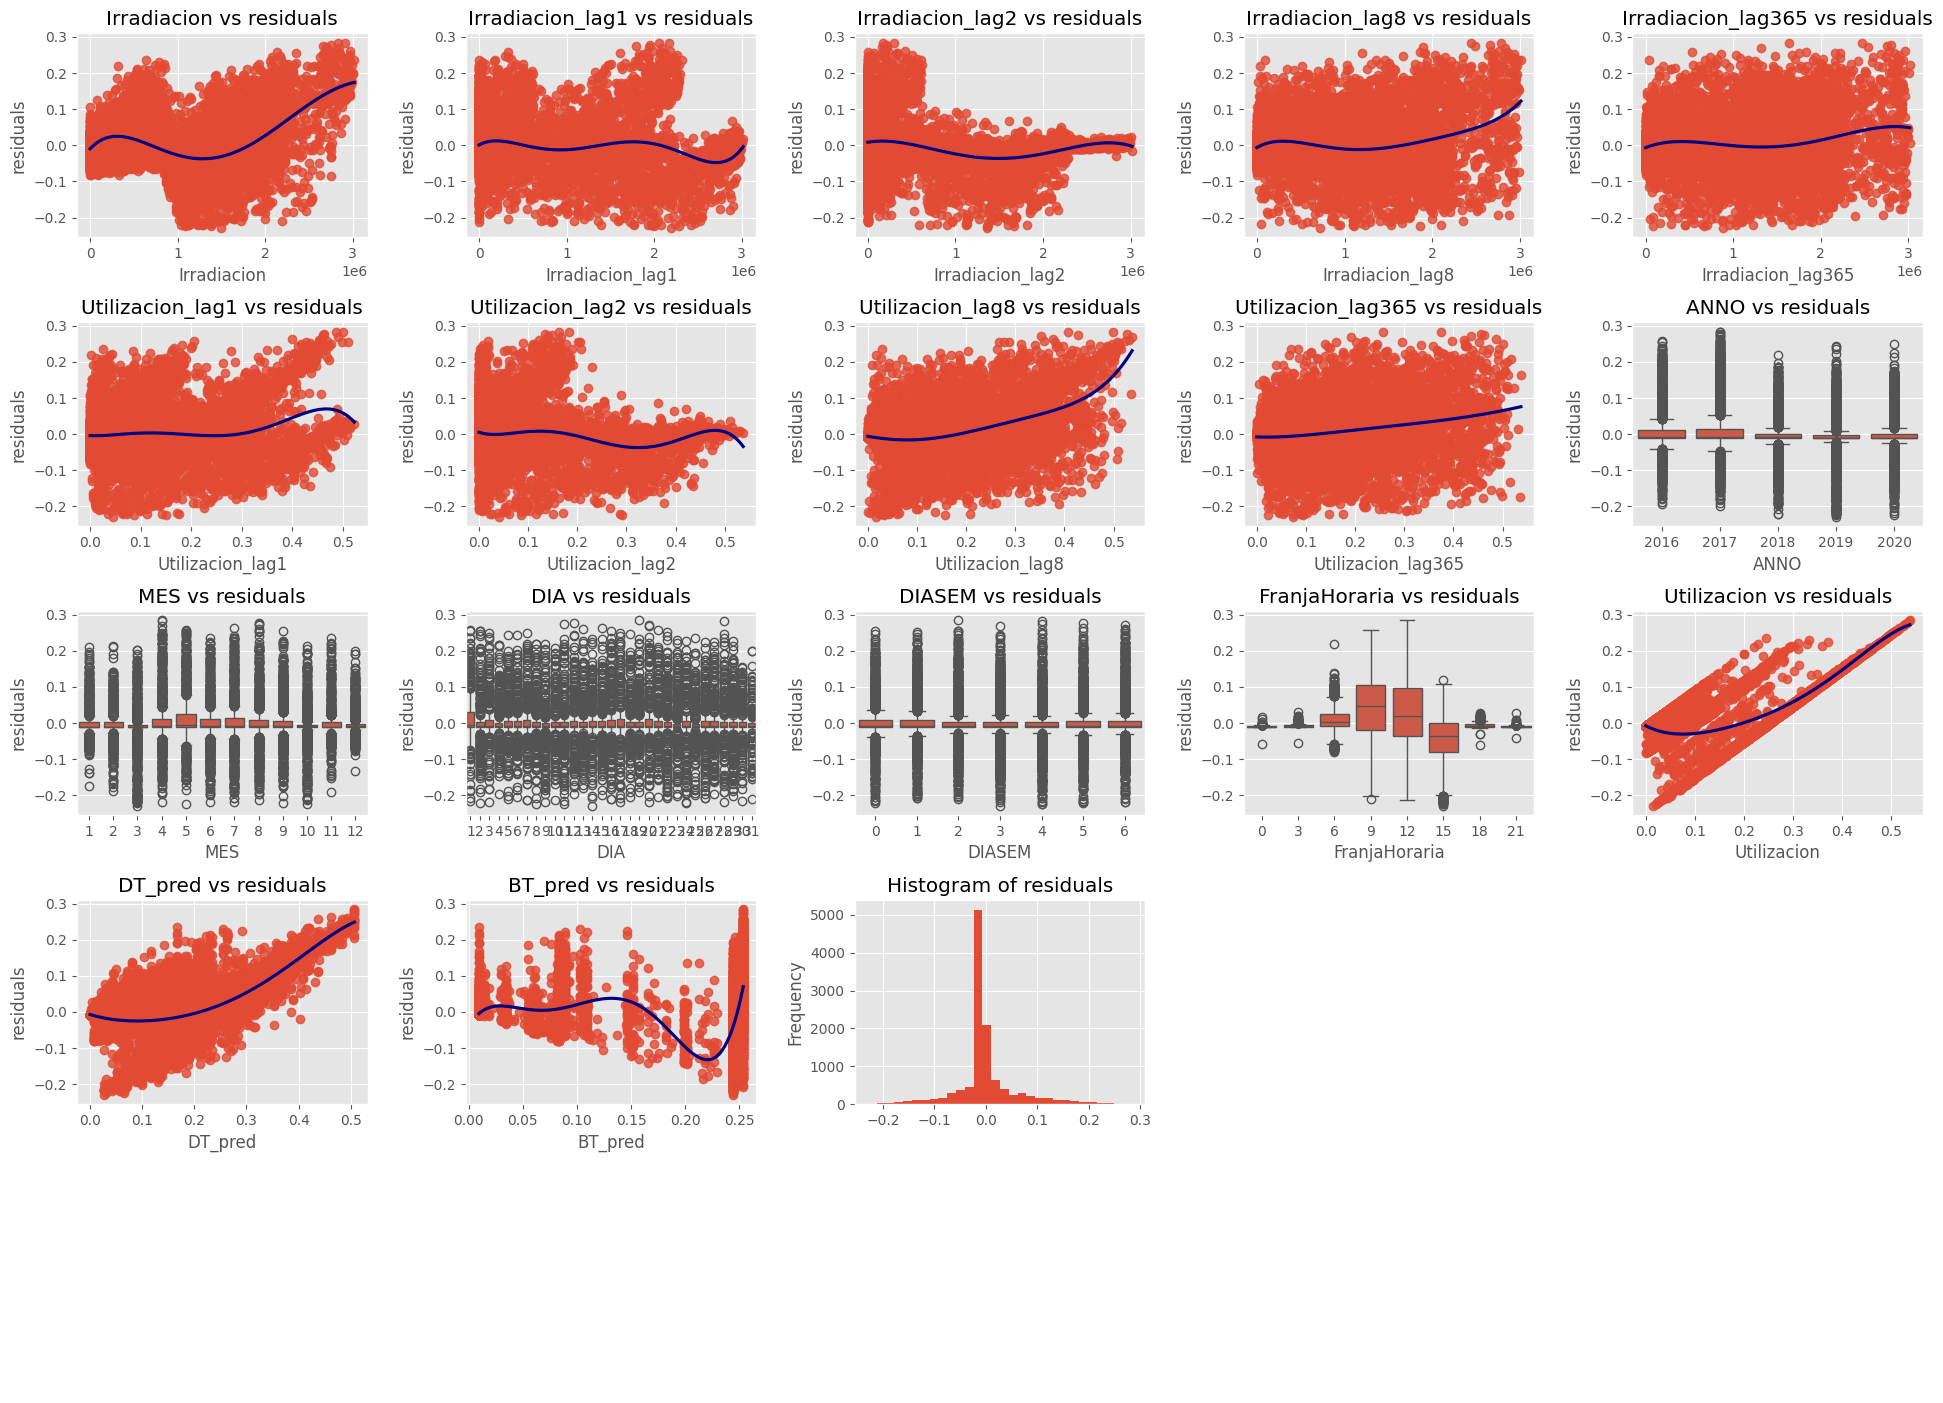

In [19]:
# Analysis of residuals
RT.plotModelDiagnosis(dfTR_eval, 'BT_pred', 'Utilizacion', figsize=[20,15])

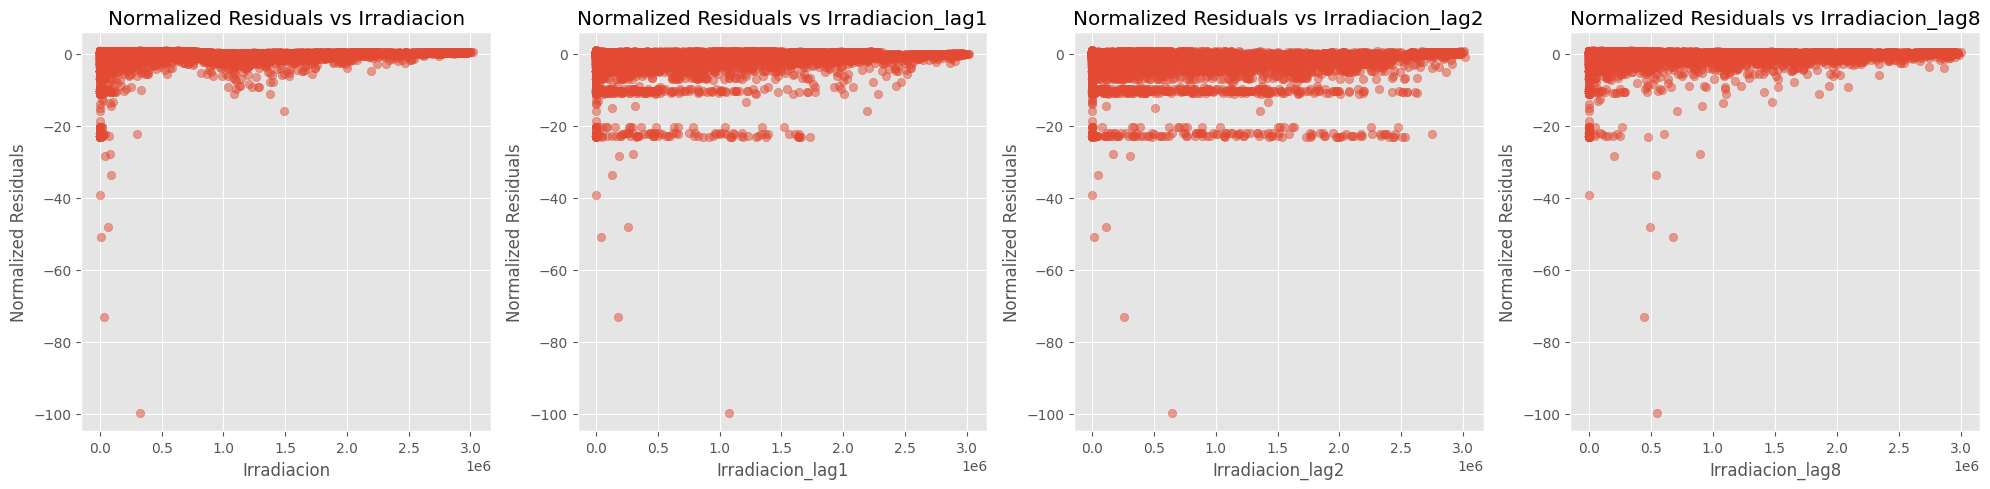

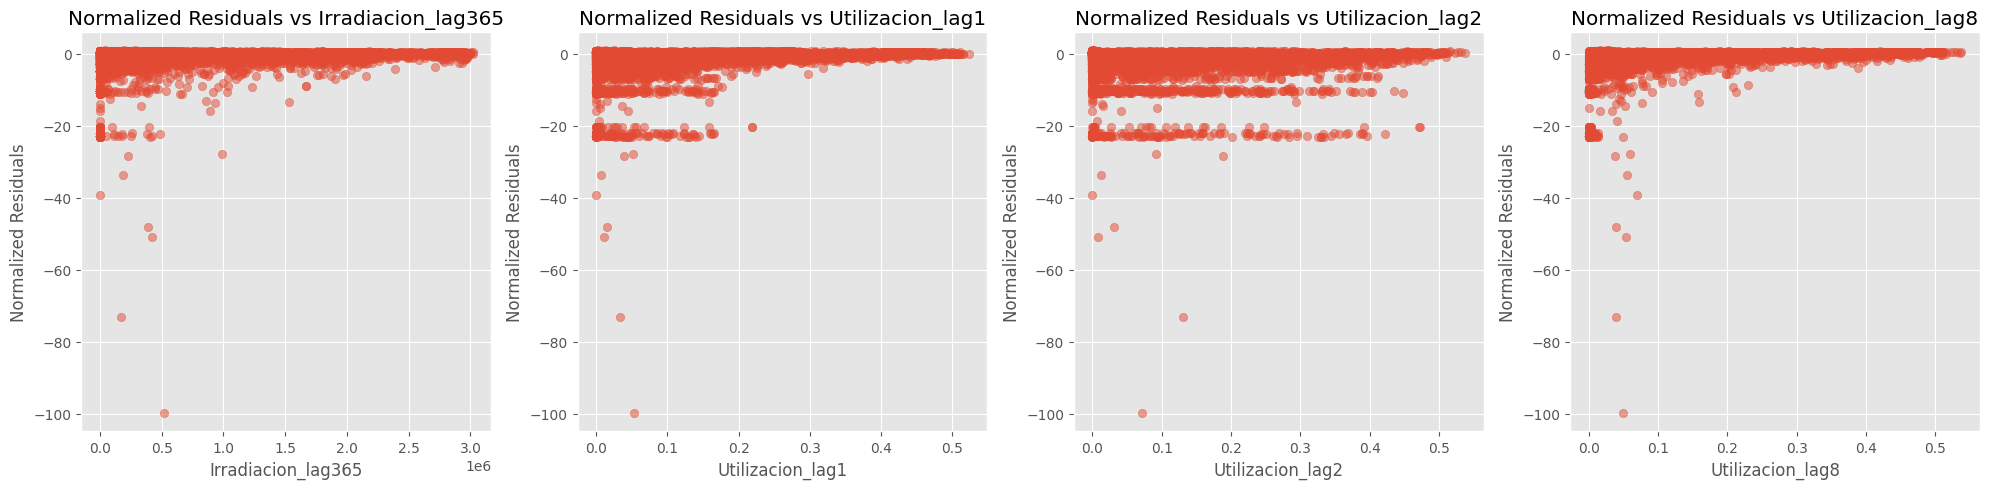

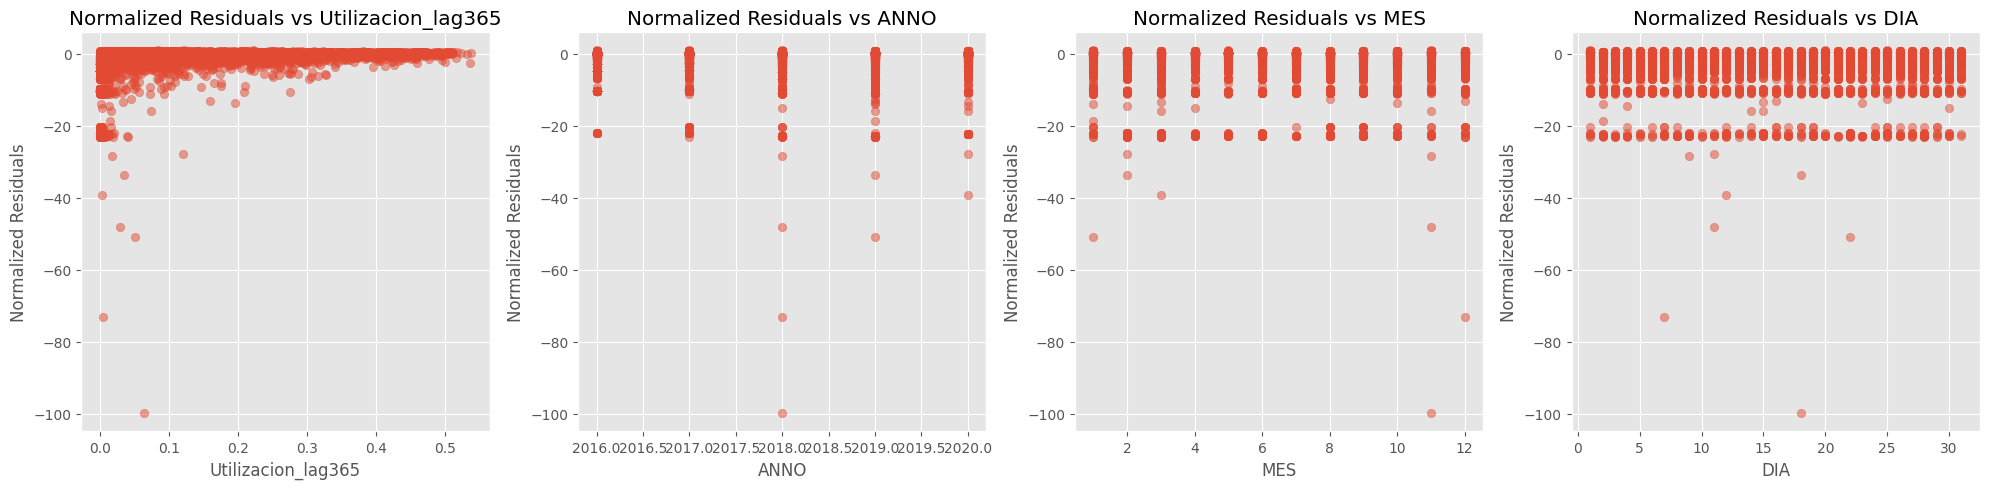

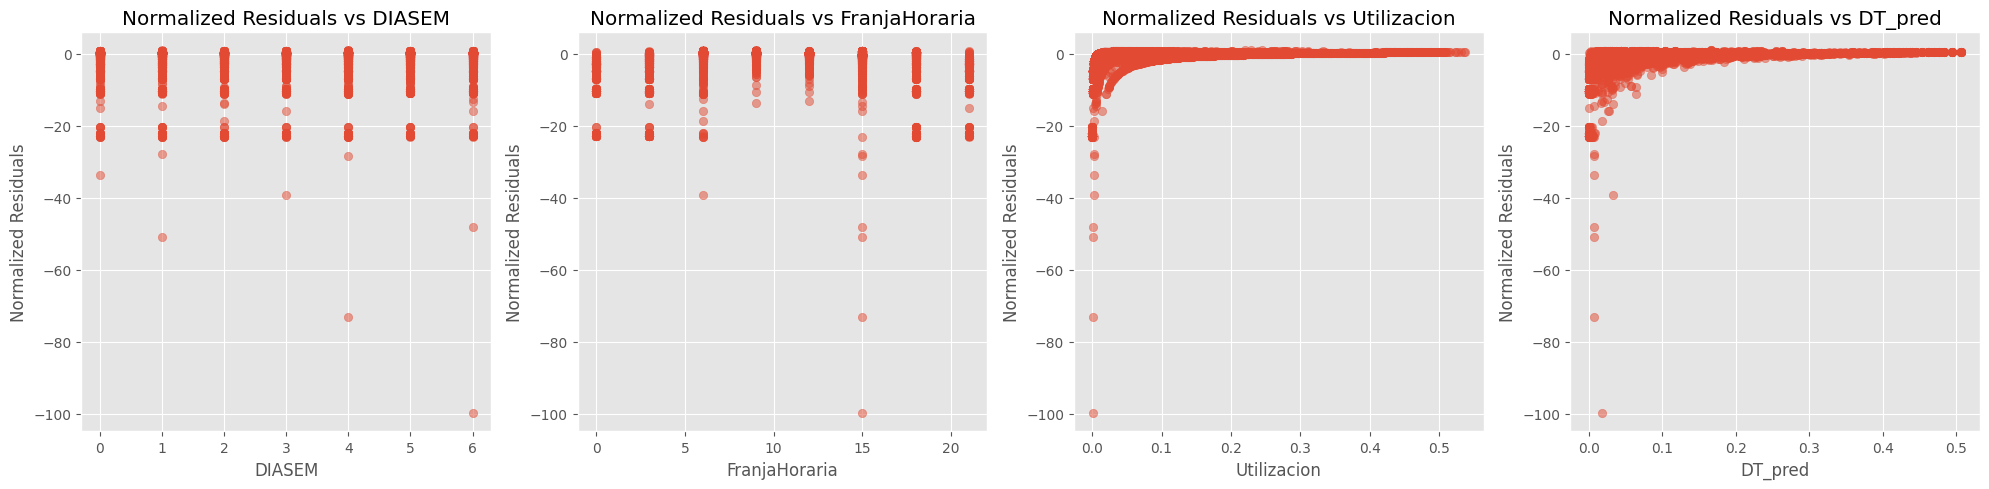

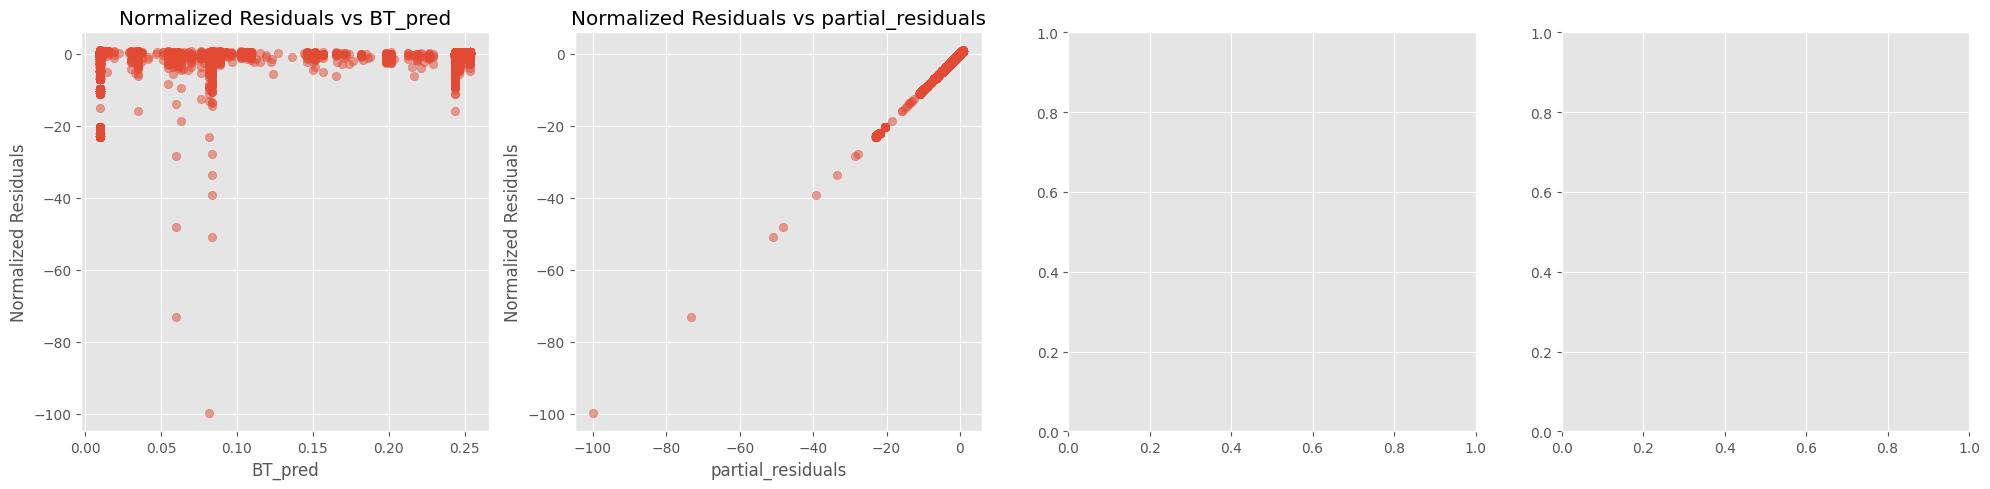

In [20]:
# Supongamos que 'data' es tu DataFrame que contiene las columnas 'residuals', 'utilizacion' y otras variables independientes
dfTR_eval['partial_residuals'] = dfTR_eval['residuals'] / dfTR_eval['Utilizacion']
# Obtén una lista de todas las variables independientes (excepto 'residuals' y 'utilizacion')
independent_variables = [column for column in dfTR_eval.columns if column not in ['residuals', 'utilizacion']]

# Calcula el número total de filas necesarias para organizar las gráficas
num_rows = int(np.ceil(len(independent_variables) / 4))

# Itera sobre cada variable independiente y grafica los residuos parciales frente a ella
for i in range(num_rows):
    fig, axes = plt.subplots(1, 4, figsize=(20, 5))
    for j in range(4):
        idx = i * 4 + j
        if idx < len(independent_variables):
            variable = independent_variables[idx]
            axes[j].scatter(dfTR_eval[variable], dfTR_eval['partial_residuals'], alpha=0.5)
            axes[j].set_title(f'Normalized Residuals vs {variable}')
            axes[j].set_xlabel(variable)
            axes[j].set_ylabel('Normalized Residuals')
            axes[j].grid(True)
    plt.tight_layout()
    plt.show()